In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

print ('Done')

Done


In [2]:
data_dir = 'disease_data'
filepaths = []
labels = []

In [4]:
folds = os.listdir(data_dir)

In [5]:
folds

['corn_blight',
 'corn_common_rust',
 'corn_gray_leaf_spot',
 'corn_healthy',
 'gram_anthracnose',
 'gram_healthy',
 'gram_leaf_crinckle',
 'gram_powdery_mildew',
 'gram_yellow_mosaic',
 'millet_blast',
 'millet_healthy',
 'millet_rust',
 'wheat_crown_and_root_rot',
 'wheat_healthy',
 'wheat_leaf_rust',
 'wheat_loose_smut']

In [6]:
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

In [7]:
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)

In [8]:
data.head()

,filepaths,labels
0,disease_data\corn_blight\Corn_Blight (1).jpeg,corn_blight
1,disease_data\corn_blight\Corn_Blight (1).jpg,corn_blight
2,disease_data\corn_blight\Corn_Blight (10).jpg,corn_blight
3,disease_data\corn_blight\Corn_Blight (100).jpg,corn_blight
4,disease_data\corn_blight\Corn_Blight (1000).JPG,corn_blight


In [9]:
classes = list(data['labels'].unique())
classes

['corn_blight',
 'corn_common_rust',
 'corn_gray_leaf_spot',
 'corn_healthy',
 'gram_anthracnose',
 'gram_healthy',
 'gram_leaf_crinckle',
 'gram_powdery_mildew',
 'gram_yellow_mosaic',
 'millet_blast',
 'millet_healthy',
 'millet_rust',
 'wheat_crown_and_root_rot',
 'wheat_healthy',
 'wheat_leaf_rust',
 'wheat_loose_smut']

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

In [11]:
train_df

,filepaths,labels
6877,disease_data\millet_blast\Blastnormal1DSC_0804...,millet_blast
7570,disease_data\millet_blast\Blastnormal2DSC_0634...,millet_blast
13600,disease_data\wheat_leaf_rust\03481.jpg,wheat_leaf_rust
2572,disease_data\corn_gray_leaf_spot\Corn_Gray_Spo...,corn_gray_leaf_spot
12101,disease_data\wheat_crown_and_root_rot\05911.jpg,wheat_crown_and_root_rot
...,...,...
1979,disease_data\corn_common_rust\Corn_Common_Rust...,corn_common_rust
12460,disease_data\wheat_crown_and_root_rot\09491.jpg,wheat_crown_and_root_rot
10372,disease_data\millet_rust\Rustnormal0DSC_0933.JPG,millet_rust
6383,disease_data\millet_blast\Blastnormal1DSC_0266...,millet_blast


In [12]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 9657 validated image filenames belonging to 16 classes.
Found 2403 validated image filenames belonging to 16 classes.
Found 3005 validated image filenames belonging to 16 classes.


In [13]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

num_classes = len(train_generator.class_indices)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Step 6: Compile the Model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)

In [15]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/25
302/302 [==============================] - 332s 1s/step - loss: 2.1211 - accuracy: 0.3524 - val_loss: 1.1503 - val_accuracy: 0.6600 - lr: 1.0000e-04
Epoch 2/25
302/302 [==============================] - 305s 1s/step - loss: 1.3379 - accuracy: 0.5564 - val_loss: 0.8303 - val_accuracy: 0.7341 - lr: 1.0000e-04
Epoch 3/25
302/302 [==============================] - 306s 1s/step - loss: 1.0897 - accuracy: 0.6247 - val_loss: 0.6872 - val_accuracy: 0.7740 - lr: 1.0000e-04
Epoch 4/25
302/302 [==============================] - 305s 1s/step - loss: 0.9643 - accuracy: 0.6663 - val_loss: 0.6183 - val_accuracy: 0.7986 - lr: 1.0000e-04
Epoch 5/25
302/302 [==============================] - 367s 1s/step - loss: 0.8547 - accuracy: 0.6941 - val_loss: 0.5533 - val_accuracy: 0.8102 - lr: 1.0000e-04
Epoch 6/25
302/302 [==============================] - 315s 1s/step - loss: 0.8147 - accuracy: 0.7077 - val_loss: 0.5189 - val_accuracy: 0.8302 - lr: 1.0000e-04
Epoch 7/25
302/302 [====================

94/94 [==============================] - 54s 572ms/step - loss: 0.3045 - accuracy: 0.8915
Test Accuracy: 89.15%


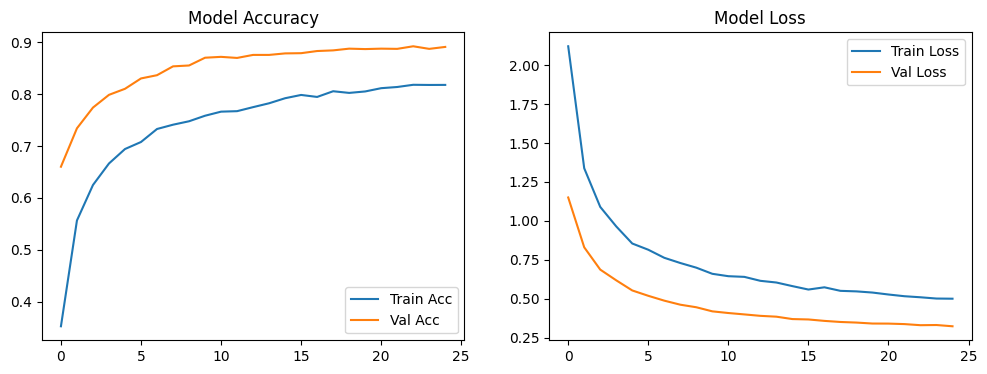

In [16]:
# Step 9: Evaluate the Model
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

# Step 10: Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [17]:
model.save("crop_disease_detection_model_3.h5")

Test Accuracy: 89.15%
94/94 [==============================] - 55s 558ms/step


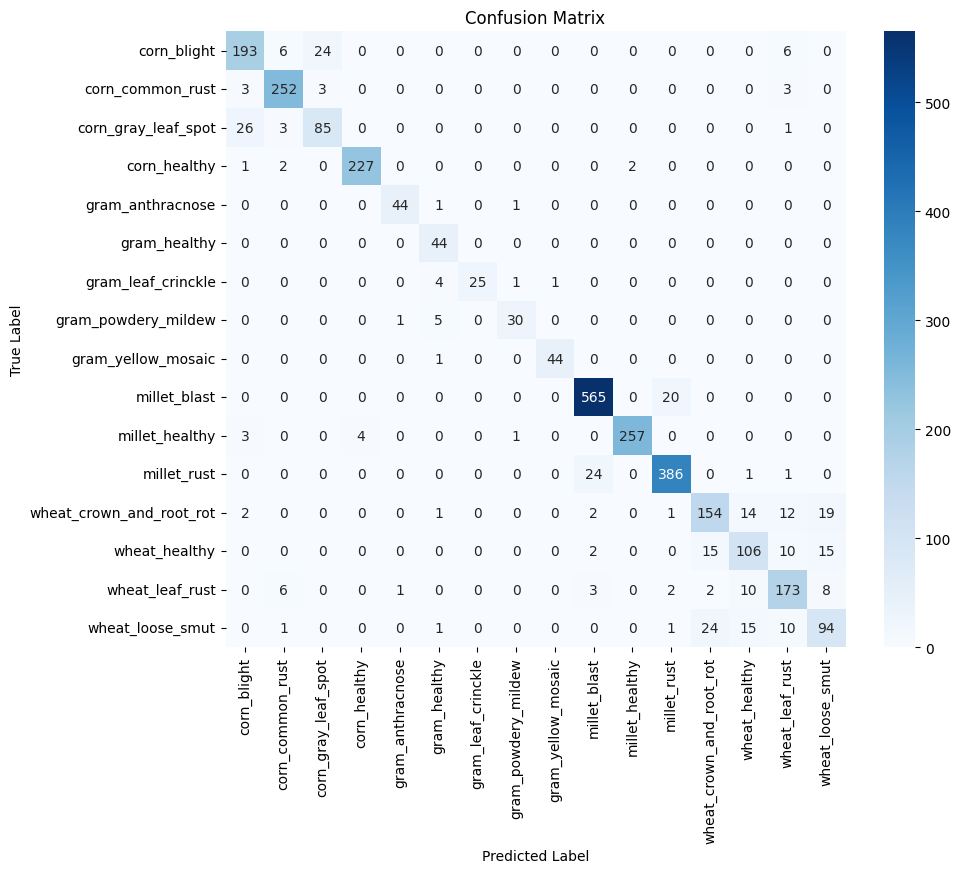

                          precision    recall  f1-score   support

             corn_blight       0.85      0.84      0.84       229
        corn_common_rust       0.93      0.97      0.95       261
     corn_gray_leaf_spot       0.76      0.74      0.75       115
            corn_healthy       0.98      0.98      0.98       232
        gram_anthracnose       0.96      0.96      0.96        46
            gram_healthy       0.77      1.00      0.87        44
      gram_leaf_crinckle       1.00      0.81      0.89        31
     gram_powdery_mildew       0.91      0.83      0.87        36
      gram_yellow_mosaic       0.98      0.98      0.98        45
            millet_blast       0.95      0.97      0.96       585
          millet_healthy       0.99      0.97      0.98       265
             millet_rust       0.94      0.94      0.94       412
wheat_crown_and_root_rot       0.79      0.75      0.77       205
           wheat_healthy       0.73      0.72      0.72       148
         

In [18]:
scores = model.evaluate(x=test_generator, verbose=0)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

y_pred = np.argmax(model.predict(test_generator), axis=1)
    
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()

print(classification_report(test_generator.classes, y_pred, target_names=classes))

In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess a single image for prediction
img_path = '34y.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Model expects batch dimension

# Predict
pred = model.predict(img_array)
predicted_class = np.argmax(pred)
class_label = list(train_generator.class_indices.keys())[predicted_class]

print("Predicted class:", class_label)

1/1 [==============================] - 3s 3s/step
Predicted class: gram_yellow_mosaic
